# Imports

In [385]:
import random
import gurobipy as gp
from gurobipy import GRB, quicksum, max_
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# Utils

In [386]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def distance_matrix_generator(switch_positions):
    # N: Number of switches
    # scale: Extent of Distance
    N = len(switch_positions)
    graph = [[0]*N for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            weight = distance(switch_positions[i], switch_positions[j])
            graph[i][j] = weight
            graph[j][i] = weight
    return graph

# Inputs

In [387]:
# Speed is not Required as time is proportional to distance
NUM_CONTROLLERS = 10
NUM_SWITCHES = 100
PACKET_IN = 10
CONTROL_CAP = 100
SCALE = 500
switch_positions = [(random.randint(0, SCALE), random.randint(0, SCALE)) for _ in range(NUM_SWITCHES)]
distance_matrix = distance_matrix_generator(switch_positions)
print(f"Data Created with {NUM_SWITCHES} switches")
print(f"Capacity of each switch: {CONTROL_CAP}")
print(f"Packet In Rate: {PACKET_IN}")

Data Created with 100 switches
Capacity of each switch: 100
Packet In Rate: 10


# Create Model

In [388]:
model = gp.Model("Controller_Placement")
print("Model Created")

## I am Assuming that controllers are associated with a switch and not in a random location.

# Is there a controller associated with the switch
associate_controller  = {}
for sw in range(NUM_SWITCHES):
    associate_controller[sw] = model.addVar(vtype=GRB.BINARY, name=f'ac_{sw}')
                                     
# Switch Controller Mapping
sw_cont_mapping = {}
for sw in range(NUM_SWITCHES):
    for con in range(NUM_SWITCHES):
        sw_cont_mapping[sw, con] = model.addVar(vtype=GRB.BINARY, name=f'map_{sw}_{con}')
    
print(f"Decision Variables Created")

Model Created
Decision Variables Created


# Constraints

### 1. Capacity Constraint

In [389]:
for con in range(NUM_SWITCHES):
    model.addConstr(quicksum(
                        PACKET_IN*sw_cont_mapping[sw, con]
                        for sw in range(NUM_SWITCHES)
                    ) <= CONTROL_CAP*associate_controller[con],
                    name=f'1_{con}')

### 2. Each switch must have a controller

In [390]:
for sw in range(NUM_SWITCHES):
    model.addConstr(quicksum(
                        sw_cont_mapping[sw, con]
                        for con in range(NUM_SWITCHES)
                    ) == 1,
                    name=f'2_{sw}')

### 3. If a switch is associated with a controller then it is mapped to the contoller

In [391]:
for con in range(NUM_SWITCHES):
    model.addConstr( sw_cont_mapping[con, con] == associate_controller[con],
                    name=f'3_{con}')

### 4. Fix the number of controllers

In [392]:
model.addConstr( quicksum(
                    associate_controller[con]
                    for con in range(NUM_SWITCHES)
                    ) == NUM_CONTROLLERS, 
                name=f'4_{con}')

<gurobi.Constr *Awaiting Model Update*>

# Objective

In [393]:
# Minimize the CC distance and CS distance

cc_distance = quicksum(
                associate_controller[sw]*associate_controller[con]*distance_matrix[sw][con]
                for sw in range(NUM_SWITCHES)
                for con in range(NUM_SWITCHES)
            )

sc_distance = quicksum(
                distance_matrix[sw][con]*sw_cont_mapping[sw, con]
                for sw in range(NUM_SWITCHES)
                for con in range(NUM_SWITCHES)
            )

model.setObjective( 0.05*cc_distance + sc_distance, GRB.MINIMIZE)

# Optimization

In [394]:
start_time = time()
max_time = 5*60 # 5 minutes

# Terminate the model after 5 minutes
def model_callback(model, where):
    if max_time < time() - start_time:
        model.terminate()

model.optimize(callback=model_callback)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 301 rows, 10100 columns and 20400 nonzeros
Model fingerprint: 0x0ae6e50c
Model has 4950 quadratic objective terms
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 6e+02]
  QObjective range [4e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 25418.373523
Presolve removed 100 rows and 100 columns
Presolve time: 0.06s
Presolved: 5151 rows, 14950 columns, 34950 nonzeros
Variable types: 0 continuous, 14950 integer (14950 binary)

Root relaxation: objective 2.529385e+03, 318 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


# Analysis

In [395]:
con_sw_map = dict()

for sw in range(NUM_SWITCHES):
    for con in range(NUM_SWITCHES):
        if sw_cont_mapping[sw, con].x == 1:
            if con not in con_sw_map:
                con_sw_map[con] = []
            con_sw_map[con].append(sw)

print(f"Objective Value: {model.objVal}")
con_sw_map

Objective Value: 6665.70932528145


{52: [0, 8, 12, 48, 49, 52, 90, 94, 95, 98],
 80: [1, 20, 24, 26, 38, 43, 73, 76, 78, 80],
 84: [2, 5, 15, 37, 42, 68, 72, 83, 84, 85],
 58: [3, 7, 41, 58, 60, 63, 70, 92, 97, 99],
 16: [4, 16, 23, 40, 47, 53, 69, 71, 75, 87],
 18: [6, 18, 21, 36, 45, 46, 51, 56, 57, 82],
 33: [9, 25, 28, 30, 33, 35, 67, 77, 88, 96],
 32: [10, 11, 29, 32, 61, 66, 74, 79, 81, 86],
 55: [13, 19, 31, 34, 50, 54, 55, 59, 89, 93],
 44: [14, 17, 22, 27, 39, 44, 62, 64, 65, 91]}

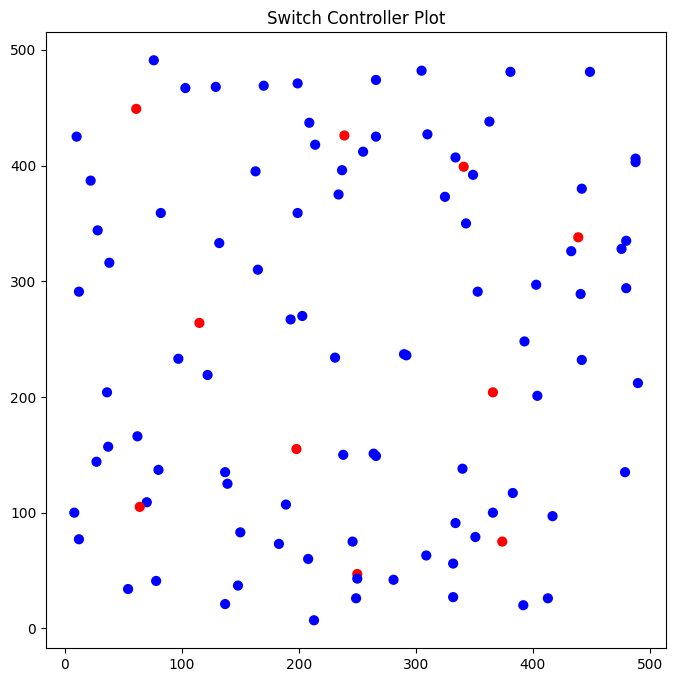

In [396]:
X = [switch_positions[i][0] for i in range(NUM_SWITCHES)]
Y = [switch_positions[i][1] for i in range(NUM_SWITCHES)]
color = ['red' if i in con_sw_map else 'blue' for i in range(NUM_SWITCHES)]

plt.figure(figsize=(8, 8))
plt.title("Switch Controller Plot")
plt.scatter(X, Y, c=color, s=40)